# **Initialize the drive and install necessary libraries**

In [ ]:
#Mount the driv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install segmententation models and torch vision
!pip install -q torch torchvision torchaudio
!pip install -q segmentation-models-pytorch albumentations tqdm opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.9 MB/s eta 0:00:00


In [ ]:
#import and install necessary
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt
# define the paths
BASE_DIR = '/content/drive/MyDrive/'
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "ISIC2018_Task1-2_Training_Input.zip")
TEST_IMG_DIR  = os.path.join(BASE_DIR, "ISIC2018_Task1-2_Test_Input.zip")
# Masks files (ISIC ground truth)
TRAIN_MASK_ZIP_CAND = os.path.join(BASE_DIR, "ISIC2018_Task1_Training_GroundTruth.zip")
TEST_MASK_ZIP_CAND= os.path.join(BASE_DIR, "ISIC2018_Task1_Test_GroundTruth.zip")

# **BASIC EDA**

In [ ]:
# Check files content.
import zipfile, os

def count_files(zip_path, exts):
    with zipfile.ZipFile(zip_path) as z:
        return len([f for f in z.namelist() if f.lower().endswith(exts)])

print("Training images:", count_files(TRAIN_IMG_DIR, ('.jpg','.jpeg')))
print("Training masks :", count_files(TRAIN_MASK_ZIP_CAND, ('.png',)))
print("Test images    :", count_files(TEST_IMG_DIR, ('.jpg','.jpeg')))

Training images: 2594
Training masks : 2594
Test images    : 1000


# **One-One image mapping check**

In [ ]:
def base_id(path): return os.path.splitext(os.path.basename(path))[0].split('_segmentation')[0]

with zipfile.ZipFile(TRAIN_IMG_DIR) as iz, zipfile.ZipFile(TRAIN_MASK_ZIP_CAND) as mz:
    imgs  = sorted([base_id(f) for f in iz.namelist() if f.lower().endswith('.jpg')])
    masks = sorted([base_id(f) for f in mz.namelist() if f.lower().endswith('.png')])

print("1–1 mapping:", len(imgs)==len(masks) and imgs==masks)

1–1 mapping: True


# **Image previews for each file.**

Total images found in /content/drive/MyDrive/ISIC2018_Task1-2_Training_Input.zip: 2594


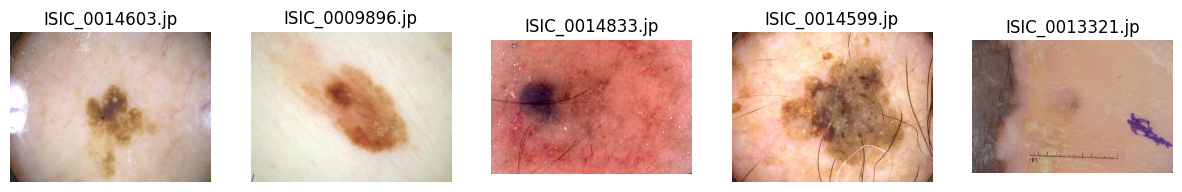

Total images found in /content/drive/MyDrive/ISIC2018_Task1-2_Test_Input.zip: 1000


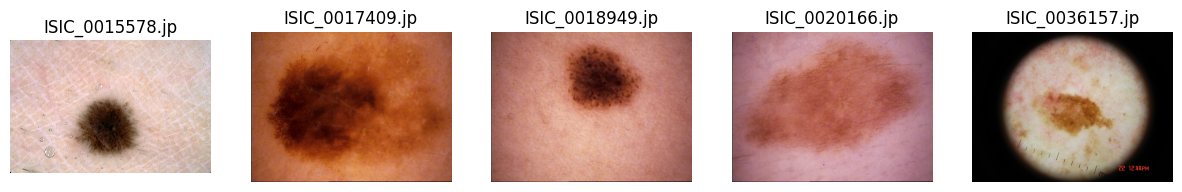

Total images found in /content/drive/MyDrive/ISIC2018_Task1_Training_GroundTruth.zip: 2594


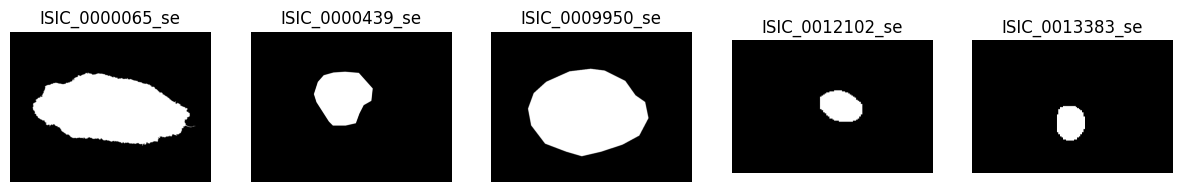

In [ ]:
# Zip image previsualization function for each folder.
import zipfile
import random
from PIL import Image
import io
import matplotlib.pyplot as plt

def preview_zip_images(zip_path, n_samples=5):
    with zipfile.ZipFile(zip_path, 'r') as z:
        # List only image files (skip folders)
        image_files = [f for f in z.namelist() if f.lower().endswith(('.png','.jpg','.jpeg'))]
        print(f"Total images found in {zip_path}: {len(image_files)}")

        # Pick some random samples
        samples = random.sample(image_files, min(n_samples, len(image_files)))

        # Plot
        plt.figure(figsize=(15, 5))
        for i, file in enumerate(samples):
            with z.open(file) as f:
                img = Image.open(io.BytesIO(f.read())).convert("RGB")
                plt.subplot(1, n_samples, i+1)
                plt.imshow(img)
                plt.title(file.split("/")[-1][:15])  # show truncated filename
                plt.axis("off")
        plt.show()

# Example usage:
preview_zip_images(TRAIN_IMG_DIR, n_samples=5)
preview_zip_images(TEST_IMG_DIR, n_samples=5)
preview_zip_images(TRAIN_MASK_ZIP_CAND, n_samples=5)

# **EDA to confirm Ratios and images sizes.**

In [ ]:
from PIL import Image
import numpy as np

widths, heights = [], []
with zipfile.ZipFile(TRAIN_IMG_DIR) as iz:
    for name in [f for f in iz.namelist() if f.lower().endswith('.jpg')][:500]:  # sample first 500
        with iz.open(name) as f:
            im = Image.open(f)
            w, h = im.size
            widths.append(w); heights.append(h)

print("Mean size: %.1f×%.1f  |  Min: %dx%d  Max: %dx%d"
      % (np.mean(widths), np.mean(heights),
         np.min(widths), np.min(heights),
         np.max(widths), np.max(heights)))

Mean size: 1593.2×1193.2  |  Min: 576x540  Max: 4288x2848


In [ ]:
ratios = []
with zipfile.ZipFile(TRAIN_MASK_ZIP_CAND) as mz:
    for name in [f for f in mz.namelist() if f.lower().endswith('.png')][:500]:
        with mz.open(name) as f:
            m = np.array(Image.open(f).convert('L'))
            ratios.append((m>0).mean())

print("Lesion pixel ratio – mean: %.2f%%  median: %.2f%%"
      % (100*np.mean(ratios), 100*np.median(ratios)))

Lesion pixel ratio – mean: 29.92%  median: 27.00%


#**AFTER EDA IS FINISHED, THE FEATURE ENGINEERING CAN START**

In [ ]:
# ====== Define a function to Find mask zips (try the common names; else search folder) ======
def find_mask_zip(base_dir, guess_path):
    if os.path.exists(guess_path):
        return guess_path
    # fallback: search for zip that contains 'ground' or 'groundtruth' or 'segmentation'
    for p in glob.glob(os.path.join(base_dir, "*.zip")):
        name = os.path.basename(p).lower()
        if ("ground" in name) or ("GroundTruth" in name) or ("segmentation" in name) or ("ground_truth" in name):
            return p
    return None

TRAIN_MASK_ZIP = find_mask_zip(BASE_DIR, TRAIN_MASK_ZIP_CAND)
TEST_MASK_ZIP  = find_mask_zip(BASE_DIR, TEST_MASK_ZIP_CAND)

if TRAIN_MASK_ZIP is None:
    print("ERROR: Could not find training masks ZIP in", BASE_DIR)
    print("Contents of BASE_DIR:", os.listdir(BASE_DIR)[:200])
    raise FileNotFoundError("Training mask ZIP not found. Upload 'ISIC2018_Task1_Training_GroundTruth.zip' or set path.")

if TEST_MASK_ZIP is None:
    print("WARNING: Could not find test mask ZIP.")


print("Using train masks:", TRAIN_MASK_ZIP)
print("Using test masks :", TEST_MASK_ZIP)


Using train masks: /content/drive/MyDrive/ISIC2018_Task1_Training_GroundTruth.zip
Using test masks : /content/drive/MyDrive/ISIC2018_Task1_Test_GroundTruth.zip


In [ ]:
# ====== Now we create Helpers: list zip image/mask files and pair by basename ======
def list_zip_files(zip_path, exts=('.jpg', '.jpeg', '.png')):
    with zipfile.ZipFile(zip_path, 'r') as z:
        files = [f for f in z.namelist() if not f.endswith('/') and f.lower().endswith(exts)]
    return sorted(files)

train_imgs_inzip = list_zip_files(TRAIN_IMG_DIR, exts=('.jpg', '.jpeg'))
train_masks_inzip = list_zip_files(TRAIN_MASK_ZIP, exts=('.png',))

print(f"Images in train zip: {len(train_imgs_inzip)}, masks in train mask zip: {len(train_masks_inzip)}")


Images in train zip: 2594, masks in train mask zip: 2594


In [ ]:
# Build dictionary for mask lookup: key = image id (basename without ext, e.g. ISIC_0000000)
def id_from_img_path(p):
    return os.path.splitext(os.path.basename(p))[0]
def id_from_mask_path(p):
    # masks typically named like ISIC_0000000_segmentation.png -> remove suffix
    name = os.path.splitext(os.path.basename(p))[0]
    return name.replace('_segmentation','')

mask_dict = { id_from_mask_path(m): m for m in train_masks_inzip }
print(f"Total items: {len(mask_dict)}")

Total items: 2594


# **Create list of pairs (image_internal_path, mask_internal_path) only for images that have masks**


In [ ]:
pairs = []
missing_masks = []
for img_path in train_imgs_inzip:
    img_id = id_from_img_path(img_path)
    mask_path = mask_dict.get(img_id)
    if mask_path:
        pairs.append((img_path, mask_path))
    else:
        missing_masks.append(img_path)

print("Paired images with masks:", len(pairs))
print("Images without masks (should be 0):", len(missing_masks))
if len(missing_masks)>0:
    print("Example missing:", missing_masks[:5])

if len(pairs) == 0:
    raise RuntimeError("No image-mask pairs found. Check mask zip naming or upload correct ground-truth zip.")

Paired images with masks: 2594
Images without masks (should be 0): 0


# **Train Validation splits for reproducibility**

In [ ]:
# ====== Train/validation split (deterministic shuffle) ======
random.seed(42)
indices = list(range(len(pairs)))
random.shuffle(indices)
split_idx = int(0.8 * len(indices))
train_idx = indices[:split_idx]
val_idx   = indices[split_idx:]

train_pairs = [pairs[i] for i in train_idx]
val_pairs   = [pairs[i] for i in val_idx]

# 🔽 Subsample to make training lighter
train_pairs = train_pairs[:500]   # reduce train set
val_pairs   = val_pairs[:200]     # reduce val set

print("Train pairs:", len(train_pairs), "Validation pairs:", len(val_pairs))



Train pairs: 500 Validation pairs: 200


In [ ]:
# ====== Dataset class that streams from ZIPs ======
class ISICZipPairDataset(Dataset):
    def __init__(self, img_zip_path, mask_zip_path, pairs, transforms=None):
        self.img_zip_path = img_zip_path
        self.mask_zip_path = mask_zip_path
        self.pairs = pairs  # list of tuples (img_internal_path, mask_internal_path)
        self.transforms = transforms

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_internal, mask_internal = self.pairs[idx]
        # Read from zips
        with zipfile.ZipFile(self.img_zip_path, 'r') as iz:
            img_bytes = iz.read(img_internal)
        with zipfile.ZipFile(self.mask_zip_path, 'r') as mz:
            mask_bytes = mz.read(mask_internal)
        # Open the images and converts them into RGB and L
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        mask = Image.open(io.BytesIO(mask_bytes)).convert('L')
        # Converts the images into np array
        img_np = np.array(img)
        mask_np = (np.array(mask) > 0).astype('float32')  # binary mask
        # conditional statements to avoid errors with scalar type Byte
        if self.transforms:
            augmented = self.transforms(image=img_np, mask=mask_np)
            img_t = augmented['image'].float() # Explicitly cast image to float32
            mask_t = augmented['mask'].unsqueeze(0).float()
            return img_t, mask_t
        else:
            img_t = torch.tensor(img_np.transpose(2,0,1)).float() / 255.0
            mask_t = torch.tensor(mask_np).unsqueeze(0).float()
            # Return the image and mask tensonrs
            return img_t, mask_t

# **Image resizing, flipping and editting.**


# **Define the transformers, & data loaders.**

In [ ]:
# ====== Transforms & DataLoaders (note: num_workers=0 recommended with zip) ======
train_transform = A.Compose([
    A.Resize(256,256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.3),
    ToTensorV2()
])

valid_transform = A.Compose([A.Resize(256,256), ToTensorV2()])

train_ds = ISICZipPairDataset(TRAIN_IMG_DIR, TRAIN_MASK_ZIP, train_pairs, transforms=train_transform)
val_ds   = ISICZipPairDataset(TRAIN_IMG_DIR, TRAIN_MASK_ZIP, val_pairs, transforms=valid_transform)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=0)

print("train_loader batches:", len(train_loader), "val_loader batches:", len(val_loader))

train_loader batches: 125 val_loader batches: 50


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# **Sanity check: Previsualization of batch images**

Batch image tensor: torch.Size([4, 3, 256, 256]) Batch masks: torch.Size([4, 1, 256, 256])


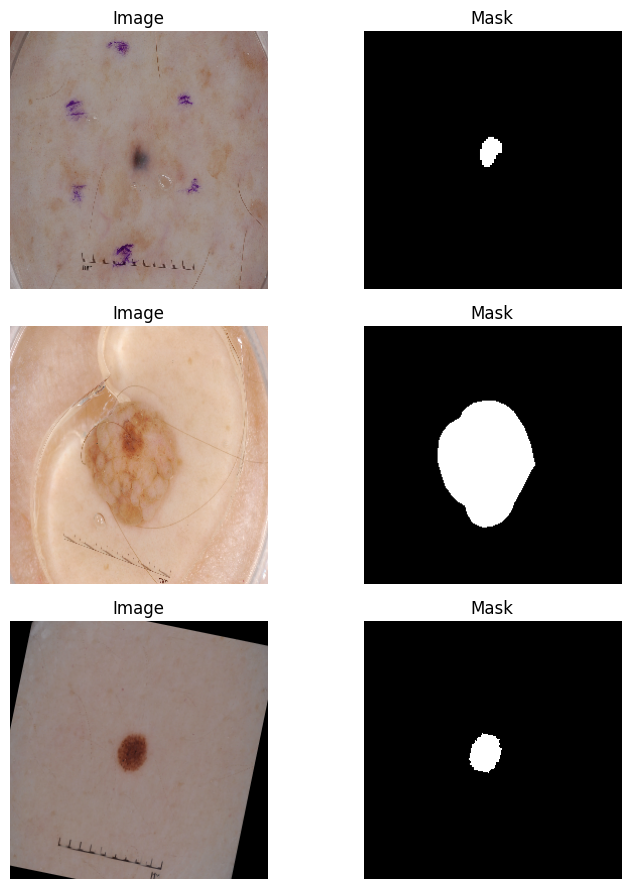

In [ ]:
# ====== 7) Quick preview of one batch (sanity check) ======
batch_imgs, batch_masks = next(iter(train_loader))
print("Batch image tensor:", batch_imgs.shape, "Batch masks:", batch_masks.shape)

# Display 3 examples from the batch
def show_batch(imgs, masks, n=3):
    imgs = imgs.cpu().numpy()
    masks = masks.cpu().numpy()
    fig, axs = plt.subplots(n, 2, figsize=(8, 3*n))
    for i in range(n):
        img = imgs[i].transpose(1,2,0)
        img = img.astype("uint8")   # convert to [0..255] integers
        mask = masks[i,0]
        axs[i,0].imshow(img)
        axs[i,0].axis('off')
        axs[i,0].set_title("Image")
        axs[i,1].imshow(mask, cmap='gray')
        axs[i,1].axis('off')
        axs[i,1].set_title("Mask")
    plt.tight_layout(); plt.show()

show_batch(batch_imgs, batch_masks, n=min(3, batch_imgs.shape[0]))

# **Define the transformers splits for training and validation**

In [ ]:
from torch.utils.data import DataLoader, random_split

# 80/20 split already created (train_pairs / val_pairs)
train_ds = ISICZipPairDataset(TRAIN_IMG_DIR, TRAIN_MASK_ZIP, train_pairs, transforms=train_transform)
val_ds   = ISICZipPairDataset(TRAIN_IMG_DIR, TRAIN_MASK_ZIP, val_pairs, transforms=valid_transform)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=0)

# **Define model, loss, optimizer, metrics**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Bloque de doble conv
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

# Definición de U-Net
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.bottom = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottom(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.out_conv(d1)

In [ ]:
# ====== LOSS FUNCTION & METRICS ======
# Dice loss en PyTorch
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    loss = 1 - ((2. * intersection + smooth) /
                (pred.sum() + target.sum() + smooth))
    return loss


In [ ]:
# IoU to avoid using torch
def iou_score(preds, targets, smooth=1e-6):
    preds = (torch.sigmoid(preds) > 0.5).float()
    targets = targets.float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)


# **Initialize the model**

In [ ]:
# ====== INICIALIZATION ======
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(in_channels=3, out_channels=1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# **Define functions for training and validations.**

In [ ]:
 ## ====== TRAINING / VALIDATION LOOPS  ======
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, total_iou = 0.0, 0.0

    for imgs, masks in loader:
        imgs, masks = imgs.to(device).float(), masks.to(device).float()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iou += iou_score(outputs, masks).item()

    return total_loss / len(loader), total_iou / len(loader)

def validate_one_epoch(model, loader, device):
    model.eval()
    total_loss, total_iou = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device).float(), masks.to(device).float()
            outputs = model(imgs)
            loss = dice_loss(outputs, masks)
            total_loss += loss.item()
            total_iou += iou_score(outputs, masks).item()

    return total_loss / len(loader), total_iou / len(loader)


# **Trainning loop to run each epoc. Adding Tolerance level if the model does not improve after 2 epochs.**

In [ ]:
# ====== TRAINNING LOOPS ======
num_epochs = 5
best_iou = 0.0
patience = 2
no_improve_epochs = 0
for epoch in range(num_epochs):
    train_loss, train_iou = train_one_epoch(model, train_loader, optimizer, DEVICE)
    val_loss, val_iou     = validate_one_epoch(model, val_loader, DEVICE)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   IoU: {val_iou:.4f}")

    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), "/content/drive/MyDrive/best_unet.pt")
        print(f"  ✅ Saved new best model with IoU {best_iou:.4f}")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("⏹️ Early stopping triggered.")
            break

KeyboardInterrupt: 

# **Display image preview: True Image - Mask - Prediction**

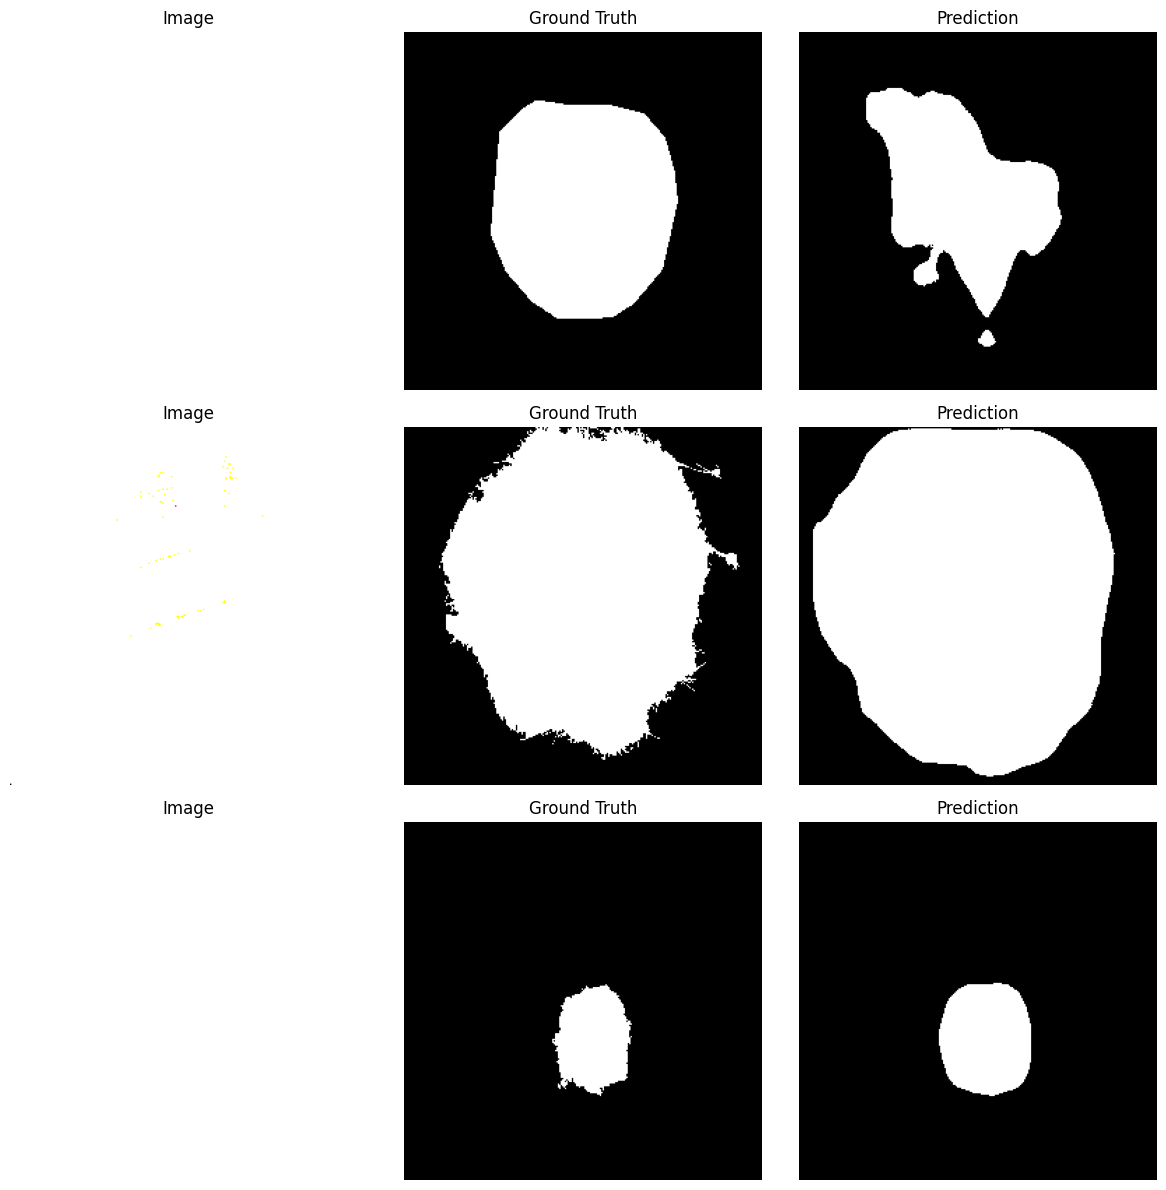

In [ ]:
import matplotlib.pyplot as plt
import random

# ====== LOAD BEST MODEL ======
model.load_state_dict(torch.load("/content/drive/MyDrive/best_unet.pt", map_location=DEVICE))
model.eval()

# ====== VISUALIZATION FUNCTION ======
def visualize_predictions(model, loader, device, num_samples=3):
    model.eval()
    samples = random.sample(range(len(loader.dataset)), num_samples)

    plt.figure(figsize=(12, num_samples * 4))
    for i, idx in enumerate(samples):
        img, mask = loader.dataset[idx]
        img_in = img.unsqueeze(0).to(device)  # add batch dim
        with torch.no_grad():
            pred = model(img_in)
            pred = torch.sigmoid(pred).cpu().squeeze().numpy()
            pred_mask = (pred > 0.5).astype("float32")

        img_np = img.permute(1,2,0).cpu().numpy()  # CHW -> HWC
        mask_np = mask.squeeze().cpu().numpy()

        # Plot
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(img_np)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ====== CALL FUNCTION ======
visualize_predictions(model, val_loader, DEVICE, num_samples=3)

# **Display overall metric results on the best model:**

In [ ]:
# ====== LOAD BEST MODEL ======
model.load_state_dict(torch.load("/content/drive/MyDrive/best_unet.pt", map_location=DEVICE))
model.eval()

# ====== METRICS FUNCTIONS ======
def dice_coef(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def pixel_accuracy(pred, target):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    correct = (pred == target).float().sum()
    total = target.numel()
    return correct / total

# ====== EVALUATE ON VALIDATION SET ======
total_dice, total_iou, total_acc = 0.0, 0.0, 0.0
count = 0

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(DEVICE).float()
        masks = masks.to(DEVICE).float()

        outputs = model(imgs)

        total_dice += dice_coef(outputs, masks).item()
        total_iou  += iou_score(outputs, masks).item()
        total_acc  += pixel_accuracy(outputs, masks).item()
        count += 1

avg_dice = total_dice / count
avg_iou  = total_iou / count
avg_acc  = total_acc / count

print(f"Validation Metrics on Best Model:")
print(f"  IoU:   {avg_iou:.4f}")
print(f"  Dice:  {avg_dice:.4f}")
print(f"  Acc:   {avg_acc:.4f}")